# –î–µ—Ç–µ–∫—Ü–∏—è –æ–±—ä–µ–∫—Ç–æ–≤ VOC2012 (YOLOv5)

## –ö–ª–æ–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ —Ä–µ–ø–æ–∑–∏—Ç–æ—Ä–∏—è –∏ –∏–º–ø–æ—Ä—Ç –±–∏–±–ª–∏–æ—Ç–µ–∫

In [2]:
# !git clone https://github.com/ultralytics/yolov5
# !cd yolov5
# !pip install -r /content/yolov5/requirements.txt

In [1]:
# –î–ª—è –∑–∞–≥—Ä—É–∑–∫–∏ –∏ –∞–Ω–∞–ª–∏–∑–∞ –¥–∞–Ω–Ω—ã—Ö
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing

# –î–ª—è —Ä–∞–±–æ—Ç—ã —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏ –∏ –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
import torch
import cv2
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [4]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
            "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

In [5]:
# –ü—É—Ç—å –¥–æ –ø–∞–ø–∫–∏ —Å –¥–∞—Ç–∞—Å–µ—Ç–æ–º
DATASET_PATH = "/content/VOCdevkit/VOC2012"
# –ü—É—Ç—å –¥–æ –ø–∞–ø–∫–∏ —Å –∞–Ω–Ω–æ—Ç–∞—Ü–∏—è–º–∏
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "Annotations")
# –ü—É—Ç—å –¥–æ –ø–∞–ø–∫–∏ —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏
IMAGES_PATH = os.path.join(DATASET_PATH, "JPEGImages")

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–∞—Ä—Å–∏–Ω–≥–∞ xml-—Ñ–∞–π–ª–æ–≤
def xml_to_csv(path = ANNOTATIONS_PATH):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            name = obj.find('name').text

            value = (root.find('filename').text,
                     width, height, name,
                     xmin, ymin, xmax, ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'name', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [6]:
xml_df = xml_to_csv()
xml_df.to_csv('xml_df.csv', index=None)
print('–ö–æ–Ω–≤–µ—Ä—Ç–∞—Ü–∏—è –ø—Ä–æ—à–ª–∞ —É—Å–ø–µ—à–Ω–æ.')

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3503/3503 [00:00<00:00, 14259.54it/s]

–ö–æ–Ω–≤–µ—Ä—Ç–∞—Ü–∏—è –ø—Ä–æ—à–ª–∞ —É—Å–ø–µ—à–Ω–æ.


In [6]:
xml_df.head()

filename  width  height       name  xmin  ymin  xmax  ymax
0  2010_000787.jpg    500     375      chair   313   122   412   234
1  2010_000787.jpg    500     375  tvmonitor   213   169   321   298
2  2010_000787.jpg    500     375  tvmonitor   342   156   461   306
3  2010_006872.jpg    500     336     person    89    68   286   333
4  2010_005276.jpg    500     281        cow   188    56   249   230

In [8]:
print(f'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–∞–ø–∏—Å–µ–π –æ–± –æ–±—ä–µ–∫—Ç–∞—Ö {xml_df.shape[0]}')
print(f'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ –¥–∞—Ç–∞—Ñ—Ä—ç–π–º–µ {len(np.unique(xml_df["filename"]))}')

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–∞–ø–∏—Å–µ–π –æ–± –æ–±—ä–µ–∫—Ç–∞—Ö 7760
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ –¥–∞—Ç–∞—Ñ—Ä—ç–π–º–µ 3503


## –û–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö

–ó–∞–∫–æ–¥–∏—Ä—É–µ–º –∫–ª–∞—Å—Å—ã –æ–±—å–µ–∫—Ç–æ–≤.

In [7]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['name'])

xml_df.head()

filename  width  height       name  xmin  ymin  xmax  ymax  class
0  2010_000787.jpg    500     375      chair   313   122   412   234      8
1  2010_000787.jpg    500     375  tvmonitor   213   169   321   298     19
2  2010_000787.jpg    500     375  tvmonitor   342   156   461   306     19
3  2010_006872.jpg    500     336     person    89    68   286   333     14
4  2010_005276.jpg    500     281        cow   188    56   249   230      9

–°–æ—Ö—Ä–∞–Ω–∏–º –∫–æ–¥–∏—Ä–æ–≤–∫—É –∫–ª–∞—Å—Å–æ–≤ –≤ –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π mapping.

In [8]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
class_id_to_name_mapping = dict(zip(mapping.values(), mapping.keys()))
class_id_to_name_mapping

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

 –ù–∞–ø–∏—à–µ–º —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏. –§—É–Ω–∫—Ü–∏—è –±—É–¥–µ—Ç –ø—Ä–∏–Ω–∏–º–∞—Ç—å –Ω–∞–∑–≤–∞–Ω–∏–µ —Ñ–∞–π–ª–∞ —Å –Ω—É–∂–Ω—ã–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ–º –∏ DataFrame —Å –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–∞–º–∏ –∏ –≤—ã–≤–æ–¥–∏—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –Ω–∞ —ç–∫—Ä–∞–Ω.

In [15]:
def plot_bounding_box(image_folder, image_filename, df=xml_df):
    # –°–æ–∑–¥–∞–µ–º –ø–æ–ª–Ω—ã–π –ø—É—Ç—å –¥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
    image_path = os.path.join(image_folder, image_filename)
    # –ß–∏—Ç–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
    img = plt.imread(image_path)
    # –°–æ–∑–¥–∞–µ–º —Ñ–∏–≥—É—Ä—É –∏ –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–Ω—É—é –ø–ª–æ—Å–∫–æ—Å—Ç—å
    fig, ax = plt.subplots(figsize=(10, 8))
    # –í—ã–≤–æ–¥–∏–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –Ω–∞ —ç–∫—Ä–∞–Ω
    ax.imshow(img);

    # –ù–∞—Ö–æ–¥–∏–º –∏–Ω–¥–µ–∫—Å –∫–∞—Ä—Ç–∏–Ω–∫–∏ –≤ DataFrame
    image_idx = df[df['filename'] == image_filename].index

    # –¢–∞–∫ –∫–∞–∫ –±–æ–∫—Å–æ–≤ –º–æ–∂–µ—Ç –±—ã—Ç—å –Ω–µ—Å–∫–æ–ª—å–∫–æ, —Å–æ–∑–¥–∞–µ–º —Ü–∏–∫–ª –ø–æ –≤—Å–µ–º –Ω–∏–º
    for i in range(len(image_idx)):
        # –ù–∞—Ö–æ–¥–∏–º –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã –ª–µ–≤–æ–π –Ω–∏–∂–Ω–µ–π —Ç–æ—á–∫–∏
        x_min = df.loc[image_idx[i], 'xmin']
        y_min = df.loc[image_idx[i], 'ymin']
        # –ù–∞—Ö–æ–¥–∏–º —à–∏—Ä–∏–Ω—É –∏ –≤—ã—Å–æ—Ç—É —Ä–∞–º–∫–∏
        box_width = df.loc[image_idx[i], 'xmax'] - df.loc[image_idx[i], 'xmin']
        box_height = df.loc[image_idx[i], 'ymax'] - df.loc[image_idx[i], 'ymin']
        name = df.loc[image_idx[i], 'name']
        # –°—Ç—Ä–æ–∏–º –ø—Ä—è–º–æ—É–≥–æ–ª—å–Ω–∏–∫
        rect = patches.Rectangle(
            (x_min, y_min),  # –ö–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã –æ–ø–æ—Ä–Ω–æ–π —Ç–æ—á–∫–∏
            box_width,  # –®–∏—Ä–∏–Ω–∞ –ø—Ä—è–º–æ—É–≥–æ–ª—å–Ω–∏–∫–∞
            box_height,  # –í—ã—Å–æ—Ç–∞ –ø—Ä—è–º–æ—É–≥–æ–ª—å–Ω–∏–∫–∞
            linewidth=1.5,  # –®–∏—Ä–∏–Ω–∞ –ª–∏–Ω–∏–∏
            edgecolor=(0, 1, 0),  # –¶–≤–µ—Ç
            facecolor='none'  # –ó–∞–ª–∏–≤–∫–∞ (none - –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç)
        )
        # –î–æ–±–∞–≤–ª—è–µ–º –ø—Ä—è–º–æ—É–≥–æ–ª—å–Ω–∏–∫ –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
        ax.add_patch(rect)
        ((text_width, text_height), _) = cv2.getTextSize(
            name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
            )
        text_rect = patches.Rectangle(
            (x_min, y_min - 2 - int(1.3 * text_height)),
            text_width * 1.1,
            text_height * 1.5,
            linewidth=0,
            edgecolor=(0, 1, 0),
            facecolor=(0, 1, 0)
        )
        ax.add_patch(text_rect)

        # –î–æ–±–∞–≤–ª—è–µ–º —Ç–µ–∫—Å—Ç–æ–≤—É—é –º–µ—Ç–∫—É (name) –∫ –ø—Ä—è–º–æ—É–≥–æ–ª—å–Ω–∏–∫—É
        ax.text(
            x_min, y_min - 2,
            name, color='w', fontsize=12
        )

    plt.show()

2010_001177.jpg


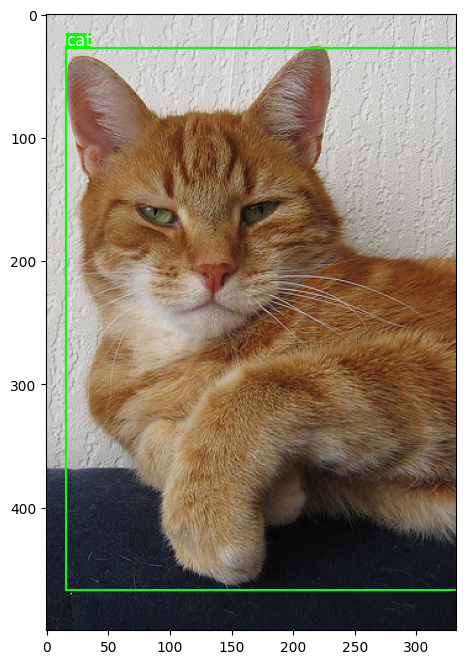

In [16]:
# –í—ã–±–µ—Ä–µ–º —Ä–∞–Ω–¥–æ–º–Ω–æ–µ —Ñ–æ—Ç–æ –∏ –≤—ã–≤–µ–¥–µ–º –µ–≥–æ —Å —Ä–∞–º–∫–∞–º–∏
random_image_filename = np.random.choice(xml_df.filename.unique())
print(random_image_filename)
plot_bounding_box(IMAGES_PATH, random_image_filename)

–û–±—É—á–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –≤ –∫–ª–∞—Å—Å–µ hub –±–∏–±–ª–∏–æ—Ç–µ–∫–∏ `torch`.

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –º–æ–¥–µ–ª–∏ –¥–ª—è –Ω–∞—à–µ–π —Ä–∞–Ω–¥–æ–º–Ω–æ–π –∫–∞—Ä—Ç–∏–Ω–∫–∏.

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 üöÄ 2024-6-3 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14.1M/14.1M [00:00<00:00, 267MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
A

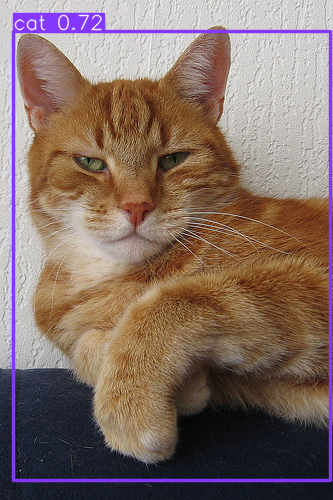

In [17]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

image_path = os.path.join(IMAGES_PATH, random_image_filename)

# Inference
results = model(image_path)

# Results
results.print()
results.show()

–ß—Ç–æ–±—ã –∏–º–µ—Ç—å –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å –æ—Ü–µ–Ω–∏—Ç—å —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏, –≤—ã–≤–µ–¥–µ–º —Å—Ç—Ä–æ–∫–∏ —Å –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–µ–π –æ–± –æ–±—ä–µ–∫—Ç–∞—Ö, –∫–æ—Ç—Ä—ã–µ –º—ã —Å–ø–∞—Ä—Å–∏–ª–∏ —Å xml-–∫–∏ —Ñ–æ—Ç–æ.

In [18]:
xml_df.loc[xml_df['filename'].isin([random_image_filename])]

filename  width  height name  xmin  ymin  xmax  ymax  class
3325  2010_001177.jpg    333     500  cat    16    27   333   467      7

## –§–æ—Ä–º–∏—Ä—É–µ–º –¥–∞—Ç–∞—Å–µ—Ç

–ú—ã –±—É–¥–µ–º –æ–±—É—á–∞—Ç—å –º–æ–¥–µ–ª—å **yolov5**. –î–ª—è –¥–∞–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –∏ –∫–ª–∞—Å—Å—ã –æ–±—ä–µ–∫—Ç–æ–≤ –¥–æ–ª–∂–Ω—ã –Ω–∞—Ö–æ–¥–∏—Ç—å—Å—è –≤ –ø–∞–ø–∫–∞—Ö images –∏ labels, —Å–æ–æ—Ç–≤–µ—Ç—Å–≤–µ–Ω–Ω–æ.

–ü–µ—Ä–µ–π–¥–µ–º –∫ —Å–æ–∑–¥–∞–Ω–∏—é –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–π. –ó–∞–¥–∞–¥–∏–º –ø—É—Ç–∏ –≤ –≤–∏–¥–µ –≥–ª–æ–±–∞–ª—å–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö:

In [19]:
DATA_PATH = "dataset/"

LABELS_PATH = os.path.join(DATA_PATH, "labels")
IMGS_PATH = os.path.join(DATA_PATH, "images")

TRAIN_IMAGES_PATH = os.path.join(IMGS_PATH, "train")
VAL_IMAGES_PATH = os.path.join(IMGS_PATH, "val")
TRAIN_LABELS_PATH = os.path.join(LABELS_PATH, "train")
VAL_LABELS_PATH = os.path.join(LABELS_PATH, "val")

DATA_CONFIG_PATH = os.path.join(DATA_PATH, "dataset.yaml")

print(TRAIN_IMAGES_PATH)
print(VAL_IMAGES_PATH)
print(TRAIN_LABELS_PATH)
print(VAL_LABELS_PATH)
print(DATA_CONFIG_PATH)

dataset/images/train
dataset/images/val
dataset/labels/train
dataset/labels/val
dataset/dataset.yaml


–¢–µ–ø–µ—Ä—å —Å–æ–∑–¥–∞–¥–∏–º –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã–µ –Ω–∞–º –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–∏.


In [20]:
# –°–æ–∑–¥–∞–µ–º –ª–æ–∫–∞–ª—å–Ω—É—é –ø–∞–ø–∫—É, –≤ –∫–æ—Ç–æ—Ä—É—é –±—É–¥–µ–º —Å–∫–ª–∞–¥—ã–≤–∞—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
# –∏ –∞–Ω–Ω–æ—Ç–∞—Ü–∏–∏ –∫ –Ω–∏–º (–µ—Å–ª–∏ —Ç–∞–∫–æ–≤–æ–π –µ—â–µ –Ω–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç)
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# –°–æ–∑–¥–∞–µ–º –ø–∞–ø–∫—É, –≥–¥–µ –±—É–¥–µ–º —Ö—Ä–∞–Ω–∏—Ç—å —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
# (–µ—Å–ª–∏ —Ç–∞–∫–∞—è –µ—â–µ –Ω–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç)
if not os.path.exists(TRAIN_IMAGES_PATH):
    os.makedirs(TRAIN_IMAGES_PATH)
# –°–æ–∑–¥–∞–µ–º –ø–∞–ø–∫—É, –≥–¥–µ –±—É–¥–µ–º —Ö—Ä–∞–Ω–∏—Ç—å —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–µ –∞–Ω–Ω–æ—Ç–∞—Ü–∏–∏ –∫ –æ–±—ä–µ–∫—Ç–∞–º
# (–µ—Å–ª–∏ —Ç–∞–∫–∞—è –µ—â–µ –Ω–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç)
if not os.path.exists(TRAIN_LABELS_PATH):
    os.makedirs(TRAIN_LABELS_PATH)

# –°–æ–∑–¥–∞–µ–º –ø–∞–ø–∫—É, –≥–¥–µ –±—É–¥–µ–º —Ö—Ä–∞–Ω–∏—Ç—å –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
# (–µ—Å–ª–∏ —Ç–∞–∫–∞—è –µ—â–µ –Ω–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç)
if not os.path.exists(VAL_IMAGES_PATH):
    os.makedirs(VAL_IMAGES_PATH)

# –°–æ–∑–¥–∞–µ–º –ø–∞–ø–∫—É, –≥–¥–µ –±—É–¥–µ–º —Ö—Ä–∞–Ω–∏—Ç—å –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–µ –∞–Ω–Ω–æ—Ç–∞—Ü–∏–∏ –∫ –æ–±—ä–µ–∫—Ç–∞–º
# (–µ—Å–ª–∏ —Ç–∞–∫–∞—è –µ—â–µ –Ω–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç)
if not os.path.exists(VAL_LABELS_PATH):
    os.makedirs(VAL_LABELS_PATH)

–î–æ–±–∞–≤–∏–º —Ñ–∞–π–ª –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ –¥–∞–Ω–Ω—ã—Ö, –Ω–∞–∑–æ–≤–µ–º –µ–≥–æ - dataset.yaml, –≤ –Ω–µ–º –ø—Ä–æ–ø–∏—à–µ–º –≤—Å–µ –ø—É—Ç–∏.

In [21]:
names = '\n    '.join(
    [f'{k}: {v}' for k, v in class_id_to_name_mapping.items()]
)

# –°–æ–∑–¥–∞–µ–º —Å–æ–¥–µ—Ä–∂–∏–º–æ–µ —Ñ–∞–π–ª–∞
data_config = f'''
path: /content/dataset
train: images/train
val: images/val
test:
names:
    {names}
'''

# –û—Ç–∫—Ä—ã–≤–∞–µ–º –Ω–∞ –∑–∞–ø–∏—Å—å —Ñ–∞–π–ª, –∫—É–¥–∞ –∑–∞–ø–∏—Å—ã–≤–∞–µ–º –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—é –ø—É—Ç–µ–π,
# –æ—Ç–∫—É–¥–∞ –±—É–¥—É—Ç –±—Ä–∞—Ç—å—Å—è –¥–∞–Ω–Ω—ã–µ –¥–ª—è –æ–±—É—á–µ–Ω–∏—è
with open(DATA_CONFIG_PATH, 'w') as f:
    f.write(data_config)

# –ü—Ä–æ–≤–µ—Ä–∏–º, —á—Ç–æ –≤—Å–µ –∑–∞–ø–∏—Å–∞–ª–æ—Å—å –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ
with open(DATA_CONFIG_PATH, 'r') as f:
    print(f.read())


path: /content/dataset
train: images/train
val: images/val
test:
names:
    0: aeroplane
    1: bicycle
    2: bird
    3: boat
    4: bottle
    5: bus
    6: car
    7: cat
    8: chair
    9: cow
    10: diningtable
    11: dog
    12: horse
    13: motorbike
    14: person
    15: pottedplant
    16: sheep
    17: sofa
    18: train
    19: tvmonitor



–†–∞–∑–¥–µ–ª–∏–º –≤—Å–µ –º–Ω–æ–∂–µ—Å—Ç–≤–æ –¥–æ—Å—Ç—É–ø–Ω—ã—Ö –Ω–∞–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏ –Ω–∞ –¥–≤–∞ –≤ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–∏ 80/20.

In [9]:
# –°–æ–∑–¥–∞–µ–º –æ–±—â–∏–π —Å–ø–∏—Å–æ–∫ –Ω–∞–∑–≤–∞–Ω–∏–π —Ñ–∞–π–ª–æ–≤ —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏
image_ids = list(set(xml_df.filename))
# –†–∞–∑–¥–µ–ª—è–µ–º —ç—Ç–æ—Ç —Å–ø–∏—Å–æ–∫ –Ω–∞ –¥–≤–∞ - —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—É—é –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –≤—ã–±–æ—Ä–∫—É
train_ids, val_ids = train_test_split(
    image_ids, random_state=42, test_size=0.2
)
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–∞–∑–º–µ—Ä—ã –≤—ã–±–æ—Ä–æ–∫
print('Train shape: {}'.format(len(train_ids)))
print('Validation shape: {}'.format(len(val_ids)))

Train shape: 2802
Validation shape: 701


In [ ]:
train_df = xml_df[xml_df['filename'].isin(train_ids)]
train_df.to_csv('train_df.csv', index=None)
valid_df = xml_df[xml_df['filename'].isin(val_ids)]
valid_df.to_csv('valid_df.csv', index=None)

–° –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏ —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å ‚Äì –æ—Å—Ç–∞–ª–æ—Å—å –ª–∏—à—å —Å–∫–æ–ø–∏—Ä–æ–≤–∞—Ç—å –∏—Ö –≤ –ø–∞–ø–∫–∏. –§–∞–π–ª—ã –∂–µ —Å –∞–Ω–Ω–æ—Ç–∞—Ü–∏—è–º–∏ –ø—Ä–µ–¥—Å—Ç–æ–∏—Ç –µ—â–µ —Å–æ–∑–¥–∞—Ç—å. –î–æ–ø–æ–ª–Ω–∏–º –¥–ª—è —ç—Ç–æ–≥–æ –Ω–∞—à –¥–∞—Ç–∞—Ñ—Ä–µ–π–º –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–µ–π: —Å—Ñ–æ—Ä–º–∏—Ä—É–µ–º —á–µ—Ç—ã—Ä–µ –Ω–æ–≤—ã—Ö —Å—Ç–æ–ª–±—Ü–∞ ‚Äì –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã —Ü–µ–Ω—Ç—Ä–∞ —Ä–∞–º–∫–∏, –µ–µ —à–∏—Ä–∏–Ω–∞ –∏ –≤—ã—Å–æ—Ç–∞.



In [23]:
# –í—ã—á–∏—Å–ª—è–µ–º –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω–Ω—ã–µ –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã —Ü–µ–Ω—Ç—Ä–∞ –æ–≥—Ä–∞–Ω–∏—á–∏–≤–∞—é—â–µ–π —Ä–∞–º–∫–∏
xml_df['x_center'] = (xml_df['xmin'] + xml_df['xmax']) / (2 * xml_df['width'])
xml_df['y_center'] = (xml_df['ymin'] + xml_df['ymax']) / (2 * xml_df['height'])

# –í—ã—á–∏—Å–ª—è–µ–º –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω—É—é –≤—ã—Å–æ—Ç—É –∏ —à–∏—Ä–∏–Ω—É –æ–≥—Ä–∞–Ω–∏—á–∏–≤–∞—é—â–µ–π —Ä–∞–º–∫–∏
xml_df['box_width'] = (xml_df['xmax'] - xml_df['xmin']).abs() / xml_df['width']
xml_df['box_height'] = (xml_df['ymax'] - xml_df['ymin']).abs() / xml_df['height']

# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
xml_df[['class','x_center','y_center','box_width','box_height']].head()

class  x_center  y_center  box_width  box_height
0      8     0.725  0.474667      0.198    0.298667
1     19     0.534  0.622667      0.216    0.344000
2     19     0.803  0.616000      0.238    0.400000
3     14     0.375  0.596726      0.394    0.788690
4      9     0.437  0.508897      0.122    0.619217

–ù–∞–∫–æ–Ω–µ—Ü, –∑–∞–ø–æ–ª–Ω–∏–º –Ω–∞—à–∏ –ø–∞–ø–∫–∏:
* –ø–∞–ø–∫–∏ —Å –∞–Ω–Ω–æ—Ç–∞—Ü–∏—è–º–∏ –∑–∞–ø–æ–ª–Ω–∏–º txt-—Ñ–∞–π–ª–∞–º–∏ —Å —Ñ–æ—Ä–º–∞—Ç–æ–º –¥–∞–Ω–Ω—ã—Ö;
* –ø–∞–ø–∫–∏ —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏ –∑–∞–ø–æ–ª–Ω–∏–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏ –∏–∑ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏—Ö –≤—ã–±–æ—Ä–æ–∫.

In [24]:
# –°–æ–∑–¥–∞–µ–º —Ü–∏–∫–ª –ø–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º
for filename, mini in tqdm(xml_df.groupby('filename')):
    # –ï—Å–ª–∏ —Ç–µ–∫—É—â–∏–π —Ñ–∞–π–ª –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –≤ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ
    if filename in val_ids:
        path2save = 'val'
    # –í –ø—Ä–æ—Ç–∏–≤–Ω–æ–º —Å–ª—É—á–∞–µ (—Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–∞—è –≤—ã–±–æ—Ä–∫–∞)
    else:
        path2save = 'train'
    # –°–æ—Å—Ç–∞–≤–ª—è–µ–º –ø—É—Ç—å –¥–æ —Ñ–∞–π–ª–∞, –∫—É–¥–∞ –∑–∞–ø–∏—à–µ–º –Ω–æ–≤—É—é –∞–Ω–Ω–æ—Ç–∞—Ü–∏—é
    new_annotation_path = os.path.join(LABELS_PATH, path2save, filename[:-4] + ".txt")
    # –û—Ç–∫—Ä—ã–≤–∞–µ–º –Ω–∞ –∑–∞–ø–∏—Å—å —Å –¥–æ–±–∞–≤–ª–µ–Ω–∏–µ–º (w+) —Ñ–∞–π–ª —Ñ–æ—Ä–º–∞—Ç–∞ .txt
    with open(new_annotation_path, 'w+') as f:
        # –í—ã–¥–µ–ª—è–µ–º –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã bounding box –≤ —Ñ–æ—Ä–º–∞—Ç–µ, —Ç—Ä–µ–±—É–µ–º—ã–º –¥–ª—è YOLOv5
        row = mini[['class','x_center','y_center','box_width','box_height']].astype(float).values
        row = row.astype(str)
        # –ü–æ—Å—Ç—Ä–æ—á–Ω–æ –∑–∞–ø–∏—Å—ã–≤–∞–µ–º –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã –∫–∞–∂–¥–æ–≥–æ –∏–∑ bounding box –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")
    # –ü–µ—Ä–µ–Ω–æ—Å–∏–º –≤ –Ω–æ–≤—É—é –ø–∞–ø–∫—É –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –∏–∑ –∏—Å—Ö–æ–¥–Ω–æ–π –ø–∞–ø–∫–∏
    shutil.copy(
        os.path.join(IMAGES_PATH, filename),
        os.path.join(IMGS_PATH, path2save, filename)
    )


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3503/3503 [00:07<00:00, 450.10it/s]


–ü—Ä–æ–≤–µ—Ä–∏–º —Ñ–∞–π–ª—ã

In [25]:
print(sorted(os.listdir(TRAIN_LABELS_PATH))[:5])
print(sorted(os.listdir(TRAIN_IMAGES_PATH))[:5])

['2010_000001.txt', '2010_000002.txt', '2010_000003.txt', '2010_000014.txt', '2010_000018.txt']
['2010_000001.jpg', '2010_000002.jpg', '2010_000003.jpg', '2010_000014.jpg', '2010_000018.jpg']


–ü–æ—Å–º–æ—Ç—Ä–∏–º, –∫–∞–∫ –≤—ã–≥–ª—è–¥—è—Ç –Ω–∞—à–∏ –∞–Ω–Ω–æ—Ç–∞—Ü–∏–∏, –Ω–∞ –ø—Ä–∏–º–µ—Ä–µ –≤—ã–±—Ä–∞–Ω–Ω–æ–≥–æ —Ñ–∞–π–ª–∞:

2010_002429.jpg
0.0 0.418 0.36421725239616615 0.584 0.3450479233226837



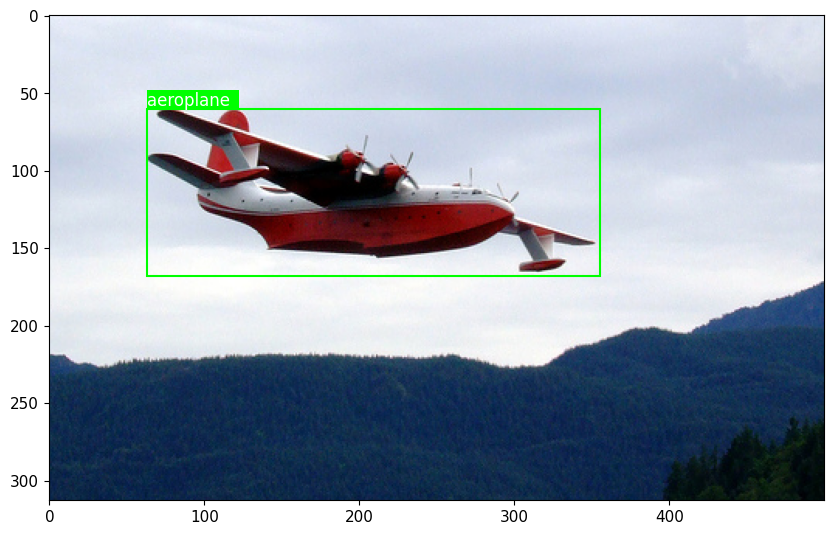

In [29]:
# –í—ã–±–µ—Ä–µ–º —Ä–∞–Ω–¥–æ–º–Ω–æ–µ —Ñ–æ—Ç–æ –∏ –≤—ã–≤–µ–¥–µ–º –µ–≥–æ —Å —Ä–∞–º–∫–∞–º–∏
img_name = np.random.choice(xml_df.filename.unique())
print(img_name)

# –û—Ç–∫—Ä–æ–µ–º —Ñ–∞–π–ª —Å –∞–Ω–Ω–æ—Ç–∞—Ü–∏–µ–π –∏ –ø—Ä–æ—á–∏—Ç–∞–µ–º —Å–æ–¥–µ—Ä–∂–∏–º–æ–µ
with open(
    os.path.join(
        TRAIN_LABELS_PATH,
        img_name.replace("jpg", "txt")
        )
    ) as f:
    txt_example = f.read()
# –í—ã–≤–µ–¥–µ–º —Å–æ–¥–µ—Ä–∂–∏–º–æ–µ –Ω–∞ —ç–∫—Ä–∞–Ω
print(txt_example)

# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ç–æ, –∫–∞–∫ –≤—ã–≥–ª—è–¥–∏—Ç —Å–∞–º–∞ –∫–∞—Ä—Ç–∏–Ω–∫–∞
plot_bounding_box(TRAIN_IMAGES_PATH, img_name)

–ü—Ä–æ–≤–µ—Ä–∏–º, —á—Ç–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–Ω–Ω–æ—Ç–∞—Ü–∏–π —Å–æ–≤–ø–∞–¥–∞–µ—Ç —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π:

In [30]:
# –ü—Ä–æ–≤–µ—Ä–∏–º, —á—Ç–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–Ω–Ω–æ—Ç–∞—Ü–∏–π —Å–æ–≤–ø–∞–¥–∞–µ—Ç —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ –∫–∞–∂–¥–æ–π –≤—ã–±–æ—Ä–∫–µ
print(len(os.listdir(TRAIN_LABELS_PATH)) == len(os.listdir(TRAIN_IMAGES_PATH)))
print(len(os.listdir(VAL_LABELS_PATH)) == len(os.listdir(VAL_IMAGES_PATH)))

True
True


## –°—Ç—Ä–æ–∏–º –º–æ–¥–µ–ª—å –¥–µ—Ç–µ–∫—Ü–∏–∏

In [31]:
!ls yolov5

benchmarks.py	 data	     LICENSE	     README.zh-CN.md   tutorial.ipynb
CITATION.cff	 detect.py   models	     requirements.txt  utils
classify	 export.py   pyproject.toml  segment	       val.py
CONTRIBUTING.md  hubconf.py  README.md	     train.py


–ó–∞—Ñ–∏–∫—Å–∏—Ä—É–µ–º –¥–∞—Ç—á–∏–∫ –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞ —Å–ª—É—á–∞–π–Ω—ã—Ö —á–∏—Å–µ–ª, —á—Ç–æ–±—ã –≤ –¥–∞–ª—å–Ω–µ–π—à–µ–º –ø–æ–ª—É—á–∞—Ç—å –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã. –î–ª—è —ç—Ç–æ–≥–æ –≤ —Ä–µ–ø–æ–∑–∏—Ç–æ—Ä–∏–∏ yolov5 –≤ –º–æ–¥—É–ª–µ utils.general –µ—Å—Ç—å —Ñ—É–Ω–∫—Ü–∏—è init_seeds(), –≤ –∫–æ—Ç–æ—Ä—É—é –Ω—É–∂–Ω–æ –ø–µ—Ä–µ–¥–∞—Ç—å –ª—é–±–æ–µ —á–∏—Å–ª–æ. –ß—Ç–æ–±—ã –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ –≤—ã–∑–≤–∞—Ç—å —ç—Ç—É —Ñ—É–Ω–∫—Ü–∏—é –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –ø–µ—Ä–µ–π—Ç–∏ –≤ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—é yolov5 –∏ –≤—ã–∑–≤–∞—Ç—å —Ñ—É–Ω–∫—Ü–∏—é, –Ω–∞—Ö–æ–¥—è—Å—å –≤ –Ω–µ–π. –î–ª—è –ø–µ—Ä–µ–º–µ—â–µ–Ω–∏—è –º–µ–∂–¥—É –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—è–º–∏ –≤–æ—Å–ø–æ–ª—å–∑—É–µ–º—Å—è —Ñ—É–Ω–∫—Ü–∏–µ–π [os.chdir()](https://docs-python.ru/standart-library/modul-os-python/funktsija-chdir-modulja-os/) –∏–∑ –º–æ–¥—É–ª—è os.

–ü–æ —Ç—Ä–∞–¥–∏—Ü–∏–∏ –≤ –∫–∞—á–µ—Å—Ç–≤–µ random_state –≤–æ–∑—å–º–µ–º 42. –ü–æ—Å–ª–µ —Ñ–∏–∫—Å–∞—Ü–∏–∏ –≤—Å–µ—Ö –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–æ–≤ —Å–ª—É—á–∞–π–Ω—ã—Ö —á–∏—Å–µ–ª –≤–µ—Ä–Ω–µ–º—Å—è –≤ –∏—Å—Ö–æ–¥–Ω—É—é —Ä–∞–±–æ—á—É—é –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—é.

In [32]:
# –ü–µ—Ä–µ–º–µ—â–∞–µ–º—Å—è –≤ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—é yolov5
os.chdir('yolov5')
# –ò–º–ø–æ—Ä—Ç–∏—Ä—É–µ–º –æ—Ç—Ç—É–¥–∞ —Ñ—É–Ω–∫—Ü–∏—é init_seeds
from utils.general import init_seeds
#–§–∏–∫—Å–∏—Ä—É–µ–º –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä —Å–ª—É—á–∞–π–Ω—ã—Ö —á–∏—Å–µ–ª –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
RANDOM_STATE = 42
init_seeds(RANDOM_STATE)
# –í–æ–∑–≤—Ä–∞—â–∞–µ–º—Å—è –æ–±—Ä–∞—Ç–Ω–æ –≤ —Ä–∞–±–æ—á—É—é –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—é
os.chdir('../')

–î–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è –ø—Ä–æ—Ü–µ—Å—Å–∞ –æ–±—É—á–µ–Ω–∏—è –≤–æ—Å–ø–æ–ª—å–∑—É–µ–º—Å—è –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç–æ–º Weights&Bias. –ê–≤—Ç–æ—Ä–∏–∑—É–µ–º—Å—è —á–µ—Ä–µ–∑ –∞–Ω–æ–Ω–∏–º–Ω—ã–π –∞–∫–∫–∞—É–Ω—Ç.

In [34]:
!pip install -q wandb --upgrade

import wandb
wandb.login(anonymous='must')

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6.7/6.7 MB 28.7 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 289.0/289.0 kB 36.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### –û–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å

–¢–µ–ø–µ—Ä—å –º—ã –º–æ–∂–µ–º –≤–æ—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è –º–æ–¥–µ–ª—å –∏ –¥–æ–æ–±—É—á–∏—Ç—å –µ–µ –ø–æ–¥ –Ω–∞—à—É –∑–∞–¥–∞—á—É.

–î–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏ –≤ —Ä–µ–ø–æ–∑–∏—Ç–æ—Ä–∏–∏ yolov5 –ø—Ä–µ–¥–Ω–∞–∑–Ω–∞—á–µ–Ω —Å–∫—Ä–∏–ø—Ç train.py. –î–ª—è –µ–≥–æ –∑–∞–ø—É—Å–∫–∞ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ —É–∫–∞–∑–∞—Ç—å —Å–ª–µ–¥—É—é—â–∏–µ –∫–ª—é—á–∏:

* `--img` - —Ä–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è, –ø–æ–¥–∞–≤–∞–µ–º–æ–≥–æ –Ω–∞ –≤—Ö–æ–¥ YOLOv5. –≠—Ç–æ –∑–Ω–∞—á–∏—Ç, —á—Ç–æ —Ä–∞–∑–º–µ—Ä –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ—Ç—Å—è –∫ –≤–∏–¥—É $n x n$, –≥–¥–µ $n$ ‚Äî —á–∏—Å–ª–æ, –≤–≤–µ–¥–µ–Ω–Ω–æ–µ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–º –ø–æ—Å–ª–µ –∫–ª—é—á–∞ ‚Äîimg;

    **–í–∞–∂–Ω–æ:**
    $n$ –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å –∫—Ä–∞—Ç–Ω–æ 32 (—ç—Ç–æ —Å–≤—è–∑–∞–Ω–æ —Å –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–æ–π YOLOv5). 32 –≤ –¥–∞–Ω–Ω–æ–º —Å–ª—É—á–∞–µ - —ç—Ç–æ —Ä–∞–∑–º–µ—Ä –æ–¥–Ω–æ–≥–æ —Å–µ–≥–º–µ–Ω—Ç–∞, –æ –∫–æ—Ç–æ—Ä–æ–º –º—ã –≥–æ–≤–æ—Ä–∏–ª–∏, –∫–æ–≥–¥–∞ –æ–±—Å—É–∂–¥–∞–ª–∏ –æ–±—â—É—é –∏–¥–µ—é —Ä–∞–±–æ—Ç—ã YOLO.
* `--batch` - —Ä–∞–∑–º–µ—Ä –±–∞—Ç—á–∞, —Ç–æ –µ—Å—Ç—å —á–∏—Å–ª–æ –∫–∞—Ä—Ç–∏–Ω–æ–∫, –ø–æ–¥–∞–≤–∞–µ–º—ã—Ö –≤ —Å–µ—Ç—å –∑–∞ –æ–¥–∏–Ω —à–∞–≥ –æ–±—É—á–µ–Ω–∏—è;
* `--epochs` - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö –æ–±—É—á–µ–Ω–∏—è, –∑–∞–¥–∞–µ—Ç —Å–∫–æ–ª—å–∫–æ —Ä–∞–∑ –¥–∞—Ç–∞—Å–µ—Ç –±—É–¥–µ—Ç –ø—Ä–æ–ø—É—â–µ–Ω —á–µ—Ä–µ–∑ –Ω–µ–π—Ä–æ–Ω–Ω—É—é —Å–µ—Ç—å –¥–ª—è –µ–µ –æ–±—É—á–µ–Ω–∏—è;
* `--data` - –ø—É—Ç—å –¥–æ —Ñ–∞–π–ª–∞ —Ñ–æ—Ä–º–∞—Ç–∞ .yaml, –∫–æ—Ç–æ—Ä—ã–π –º—ã —Å–æ–∑–¥–∞–≤–∞–ª–∏ –≤—ã—à–µ;
* `--weights` - –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã–µ –≤–µ—Å–∞, –∏—Å–ø–æ–ª—å–∑—É–µ–º—ã–µ –º–æ–¥–µ–ª—å—é;
* `--name` - –∏–º—è –ø–∞–ø–∫–∏, –∫—É–¥–∞ —Å–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –æ–±—É—á–µ–Ω–∏—è.

–ö–ª—é—á `--weights` –æ—Ç–≤–µ—á–∞–µ—Ç –∑–∞ –≤—ã–±–æ—Ä –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏.

In [35]:
# –ó–∞–ø—É—Å–∫–∞–µ–º —Ñ–∞–π–ª train.py —Å–æ —Å–∫—Ä–∏–ø—Ç–æ–º –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏

!python yolov5/train.py \
--img 500 \
--batch 16 \
--epochs 30 \
--data {DATA_CONFIG_PATH} \
--weights yolov5s.pt \
--name my_yolov5_model_s

wandb: WARNING ‚ö†Ô∏è wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-06-03 16:30:52.011567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 16:30:52.011626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 16:30:52.111645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: anony-mouse-553881299929238195. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=dataset/dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch

### –í–∞–ª–∏–¥–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å

In [38]:
!ls yolov5/runs/train/my_yolov5_model_s/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1717432258.331b22433aec.3373.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –≥—Ä–∞—Ñ–∏–∫–∏, –Ω–∞–∏–±–æ–ª–µ–µ –æ–±—â–∞—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è, –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è—é—â–∞—è –¥–ª—è –Ω–∞—Å –∏–Ω—Ç–µ—Ä–µ—Å —Å–æ–¥–µ—Ä–∂–∏—Ç—Å—è –≤ —Ñ–∞–π–ª–µ results.png.

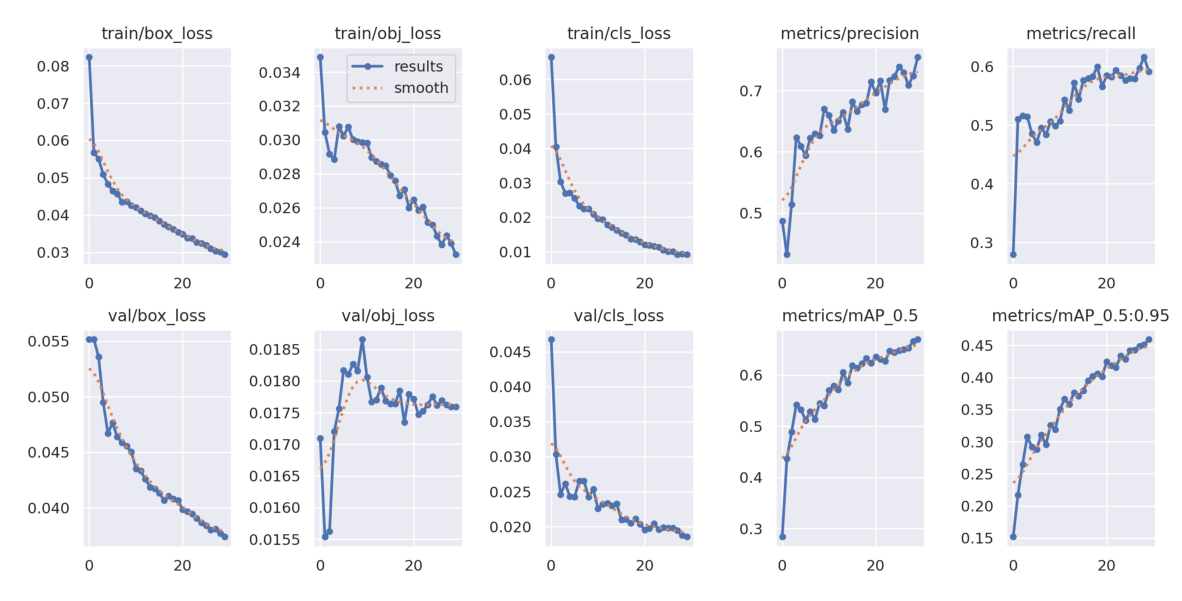

In [39]:
# –ß–∏—Ç–∞–µ–º —Ñ–∞–π–ª —Å –≥—Ä–∞—Ñ–∏–∫–∞–º–∏ –ø—Ä–æ—Ü–µ—Å—Å–∞ –æ–±—É—á–µ–Ω–∏—è
results = plt.imread('/content/yolov5/runs/train/my_yolov5_model_s/results.png')
# –û—Ç–æ–±—Ä–∞–∂–∞–µ–º –≥—Ä–∞—Ñ–∏–∫–∏
fig, ax = plt.subplots(figsize=(15,12))
ax.axis('off')
ax.imshow(results);

–í –ø–∞–ø–∫–µ runs/result/weights —Ö—Ä–∞–Ω—è—Ç—Å—è 2 —Ñ–∞–π–ª–∞ —Å –≤–µ—Å–∞–º–∏ (–ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ –Ω–µ–π—Ä–æ–Ω–Ω–æ–π —Å–µ—Ç–∏):
* best.pt ‚Äî —Ñ–∞–π–ª, –≤ –∫–æ—Ç–æ—Ä–æ–º —Å–æ—Ö—Ä–∞–Ω–µ–Ω –ª—É—á—à–∏–π –≤–∞—Ä–∏–∞–Ω—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –º–æ–¥–µ–ª–∏ –∑–∞ –≤—Å–µ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è
* last.pt ‚Äî —Ñ–∞–π–ª, –≤ –∫–æ—Ç–æ—Ä–æ–º —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤–µ—Å–∞, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–¥–µ–ª—å –ø–æ–ª—É—á–∏–ª–∞ –Ω–∞ –ø–æ—Å–ª–µ–¥–Ω–µ–π —ç–ø–æ—Ö–µ –æ–±—É—á–µ–Ω–∏—è

In [40]:
!ls yolov5/runs/train/my_yolov5_model_s/weights

best.pt  last.pt


–ó–∞–≥—Ä—É–∑–∏–º –Ω–∞–∏–ª—É—á—à–∏–µ –≤–µ—Å–∞ –≤ –Ω–∞—à—É –º–æ–¥–µ–ª—å.


In [42]:
# –ü—É—Ç—å –¥–æ –º–µ—Å—Ç–∞, –≥–¥–µ —Ö—Ä–∞–Ω—è—Ç—Å—è –ª—É—á—à–∏–µ –≤–µ—Å–∞
BEST_WEIGHTS_PATH = '/content/yolov5/runs/train/my_yolov5_model_s/weights/best.pt'
# –ó–∞–≥—Ä—É–∂–∞–µ–º –ª—É—á—à–∏–µ –≤–µ—Å–∞
yolov5 = torch.hub.load(
    repo_or_dir='yolov5',
    model='custom',
    path=BEST_WEIGHTS_PATH,
    source='local'
)
# –ü–æ–Ω–∏–∑–∏–º –ø–æ—Ä–æ–≥ –¥–æ–ø—É—Å—Ç–∏–º–æ–π —É–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏
yolov5.conf = 0.01

YOLOv5 üöÄ 2024-6-3 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


–ü—Ä–æ–≤–µ—Ä–∏–º —Ä–∞–±–æ—Ç—É –Ω–∞—à–µ–π –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏, –≤–æ–∑—å–º–µ–º –∫–∞–∫—É—é-–Ω–∏–±—É–¥—å –∫–∞—Ä—Ç–∏–Ω–∫—É –∏ –ø–æ–¥–∞–¥–∏–º –µ–µ –Ω–∞ –≤—Ö–æ–¥ –º–æ–¥–µ–ª–∏.

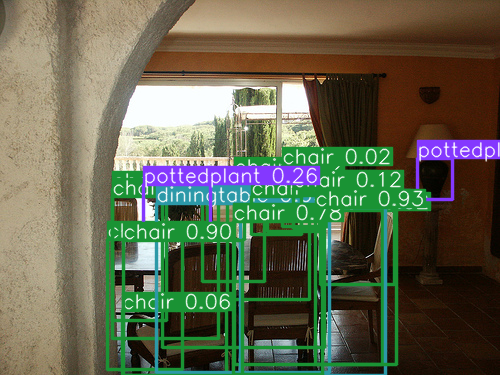

In [43]:
# –ü—É—Ç—å –¥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
image_filename = '2010_000463.jpg'
image_path = os.path.join(IMAGES_PATH, image_filename)
# –ü—Ä–æ–ø—É—Å–∫–∞–µ–º –∫–∞—Ä—Ç–∏–Ω–∫—É —á–µ—Ä–µ–∑ –º–æ–¥–µ–ª—å
prediction = yolov5(image_path)
# –û—Ç–æ–±—Ä–∞–∂–∞–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
prediction.show()

2010_001796.jpg


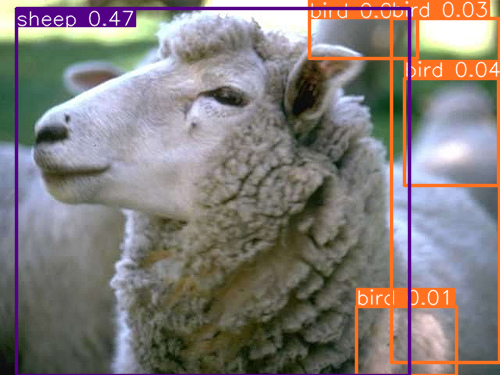

In [44]:
# –í—ã–±–µ—Ä–µ–º —Ä–∞–Ω–¥–æ–º–Ω–æ–µ —Ñ–æ—Ç–æ –∏ –≤—ã–≤–µ–¥–µ–º –µ–≥–æ —Å —Ä–∞–º–∫–∞–º–∏
random_image_idx = np.random.choice(xml_df.shape[0])
image_filename = xml_df.loc[random_image_idx, 'filename']
print(image_filename)
# –ü—É—Ç—å –¥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
image_path = os.path.join(IMAGES_PATH, image_filename)
# –ü—Ä–æ–ø—É—Å–∫–∞–µ–º –∫–∞—Ä—Ç–∏–Ω–∫—É —á–µ—Ä–µ–∑ –º–æ–¥–µ–ª—å
prediction = yolov5(image_path)
# –û—Ç–æ–±—Ä–∞–∂–∞–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
prediction.show()

–ü—Ä–æ–±–µ–∂–∏–º—Å—è –ø–æ –≤—Å–µ–º —Ñ–æ—Ç–æ –∏ —Å–¥–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è.

In [45]:
# –°–ø–∏—Å–æ–∫ –≤—Å–µ—Ö —Ñ–∞–π–ª–æ–≤ —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏
filenames = xml_df['filename']
# –°–æ–∑–¥–∞–µ–º –ø—É—Å—Ç–æ–π DataFrame
preds_df = pd.DataFrame()
# –°–æ–∑–¥–∞–µ–º —Ü–∏–∫–ª –ø–æ –≤—Å–µ–º —Ñ–∞–π–ª–∞–º–∏
for filename in tqdm(filenames):
    # –°–æ—Å—Ç–∞–≤–ª—è–µ–º –ø—É—Ç—å –¥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
    image_path = os.path.join(IMAGES_PATH, filename)
    # –ü—Ä–æ–ø—É—Å–∫–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ —á–µ—Ä–µ–∑ –º–æ–¥–µ–ª—å
    prediction = yolov5(image_path)
    # –ö–æ–Ω–≤–µ—Ä—Ç–∏—Ä—É–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –≤ DataFrame
    pred_rows = prediction.pandas().xyxy[0]
    # –î–æ–±–∞–≤–ª—è–µ–º –≤ DataFrame —Å—Ç–æ–ª–±–µ—Ü —Å –∏–º–µ–Ω–µ–º —Ñ–∞–π–ª–∞ –¥–ª—è —è—Å–Ω–æ—Å—Ç–∏
    pred_rows['filename'] = filename
    # –ö–æ–Ω–∫–∞—Ç–µ–Ω–∏—Ä—É–µ–º –ø–æ–ª—É—á–µ–Ω–Ω—ã–π DataFrame –∫ –æ–±—â–µ–π —Ç–∞–±–ª–∏—Ü–µ
    preds_df = pd.concat([preds_df, pred_rows])

# –°–±—Ä–∞—Å—ã–≤–∞–µ–º –∏–Ω–¥–µ–∫—Å
preds_df = preds_df.reset_index(drop=True)
preds_df.head()

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7760/7760 [02:35<00:00, 49.76it/s]


xmin        ymin        xmax        ymax  confidence class  \
0  212.211868  165.160263  322.384186  295.545898    0.852803    19   
1  319.985474  119.632324  414.322266  239.832977    0.846546     8   
2  343.797852  155.625259  457.885223  299.264252    0.779895    19   
3  237.713333  216.360229  299.746033  296.253693    0.066853    19   
4   37.380947  256.225616  190.822418  374.808716    0.036437     8   

        name         filename  
0  tvmonitor  2010_000787.jpg  
1      chair  2010_000787.jpg  
2  tvmonitor  2010_000787.jpg  
3  tvmonitor  2010_000787.jpg  
4      chair  2010_000787.jpg

In [46]:
print('–ò—Å—Ö–æ–¥–Ω–æ–µ —á–∏—Å–ª–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π:              ', len(image_ids))
print('–ß–∏—Å–ª–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ —Ç–∞–±–ª–∏—Ü–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π:', preds_df.filename.nunique())
print('–ß–∏—Å–ª–æ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–Ω—ã—Ö –æ–±—ä–µ–∫—Ç–æ–≤:             ', preds_df.shape[0])

–ò—Å—Ö–æ–¥–Ω–æ–µ —á–∏—Å–ª–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π:               3503
–ß–∏—Å–ª–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ —Ç–∞–±–ª–∏—Ü–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π: 3502
–ß–∏—Å–ª–æ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–Ω—ã—Ö –æ–±—ä–µ–∫—Ç–æ–≤:              86145


–ß–∏—Å–ª–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ –∏—Å—Ö–æ–¥–Ω–∏–∫–µ –∏ –≤ —Ç–∞–±–ª–∏—Ü–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –Ω–µ —Å—Ö–æ–¥–∏—Ç—Å—è...

–≠—Ç–æ –ø—Ä–æ–∏–∑–æ—à–ª–æ –ø–æ—Ç–æ–º—É, —á—Ç–æ –∑–∞–¥–∞–Ω–Ω—ã–π –Ω–∞–º–∏ –ø–æ—Ä–æ–≥ —É–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏ –æ–∫–∞–∑–∞–ª—Å—è –≤—ã—à–µ, —á–µ–º —Ç—Ä–µ–±–æ–≤–∞–ª–æ—Å—å –¥–ª—è –∑–∞—Å—á–∏—Ç—ã–≤–∞–Ω–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è:

In [47]:
print('Max confidence:', preds_df.confidence.max())
print('Min confidence:', preds_df.confidence.min())

Max confidence: 0.9698991775512695
Min confidence: 0.01000039093196392


–†–∞–∑–¥–µ–ª–∏–º —Ç–∞–±–ª–∏—Ü—É —Å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è–º–∏ –Ω–∞ –¥–≤–∞ –¥—Ä—É–≥–∏—Ö —Å–æ–≥–ª–∞—Å–Ω–æ –≤—ã–±–æ—Ä–∫–∞–º ‚Äì —Ç—Ä–µ–Ω–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–º—É –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–º—É.

In [48]:
# –û—Ç–±–∏—Ä–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –¥–ª—è —Ç—Ä–µ–Ω–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏
train_preds_df = preds_df[preds_df['filename'].isin(train_ids)]

# –û—Ç–±–∏—Ä–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏
val_preds_df = preds_df[preds_df['filename'].isin(val_ids)]

–°–æ—Ö—Ä–∞–Ω–∏–º DataFrame —Å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–º–∏ –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–∞–º–∏ bounding box-–æ–≤, —á—Ç–æ–±—ã –≤–ø–æ—Å–ª–µ–¥—Å—Ç–≤–∏–∏ –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞—Ç—å —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã.

In [49]:
#–°–æ—Ö—Ä–∞–Ω—è–µ–º –ø–æ–ª—É—á–µ–Ω–Ω—ã–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –≤ –≤–∏–¥–µ —Ç–∞–±–ª–∏—Ü—ã
train_preds_df.to_csv('/content/dataset/yolov5_train_predictions.csv', index=False)
val_preds_df.to_csv('/content/dataset/yolov5_val_predictions.csv', index=False)

## –°—á–∏—Ç–∞–µ–º accuracy

In [10]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—Å—á–µ—Ç–∞ –ø–ª–æ—â–∞–¥–∏ –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏—è –¥–≤—É—Ö –ø—Ä—è–º–æ—É–≥–æ–ª—å–Ω–∏–∫–æ–≤
def calculate_iou(box1, box2):
    x_left = max(box1['xmin'], box2['xmin'])
    y_top = max(box1['ymin'], box2['ymin'])
    x_right = min(box1['xmax'], box2['xmax'])
    y_bottom = min(box1['ymax'], box2['ymax'])

    if x_right < x_left or y_bottom < y_top:
        return 0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    box1_area = (box1['xmax'] - box1['xmin']) * (box1['ymax'] - box1['ymin'])
    box2_area = (box2['xmax'] - box2['xmin']) * (box2['ymax'] - box2['ymin'])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou


def calculate_detection_accuracy(
    true_df=None, preds=None,
    iou_threshold=0.5, confidence_threshold=0.25,
    get_report=False
    ):
    total_objects = len(true_df)
    correct_objects = 0
    true_val_cnts_dct = dict(true_df.name.value_counts())
    pred_val_cnts_dct = {key: 0 for key in list(true_val_cnts_dct.keys())}
    
    for filename in list(true_df.filename.unique()):
        true_boxes = true_df[true_df['filename'] == filename]
        pred_boxes = preds[preds['filename'] == filename]
        
        for _, true_row in true_boxes.iterrows():
            detected = [0]
            valid_box = {
                'xmin': true_row['xmin'],
                'ymin': true_row['ymin'],
                'xmax': true_row['xmax'],
                'ymax': true_row['ymax']
            }
            true_class = true_row['name']
            for _, pred_row in pred_boxes.iterrows():
                confidence = pred_row['confidence']
                if confidence >= confidence_threshold:
                    pred_box = {
                        'xmin': pred_row['xmin'],
                        'ymin': pred_row['ymin'],
                        'xmax': pred_row['xmax'],
                        'ymax': pred_row['ymax']
                    }
                    pred_class = pred_row['name']
                    
                    iou = calculate_iou(pred_box, valid_box)
                    if iou >= iou_threshold:
                        if pred_class == true_class:
                            detected.append(1)
            
            correct_objects += max(detected)
            pred_val_cnts_dct[true_class] += max(detected)

    accuracy = correct_objects / total_objects
    if get_report:
        print('Class name: |  Acc:  |true:|pred:|')
        print('-'*34)
        for k, v in true_val_cnts_dct.items():
            detected_cnt = pred_val_cnts_dct[k]
            print(
                f'{k}'.ljust(11), f'| {detected_cnt/v:.4f} | {v}'.ljust(14),
                f'| {detected_cnt}'.ljust(5), '|')
        print('-'*34)
        print(f'Total Accuracy: {accuracy:.4f}')
    else:
        return accuracy 

–ú–æ–∂–µ–º –ø–æ—Å—Ç—Ä–æ–∏—Ç—å –ø–æ–≤–µ—Ä—Ö–Ω–æ—Å—Ç—å accuracy –ø—Ä–∏ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏—è—Ö IoU –∏ —É–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏.

In [11]:
iou_thresholds = np.arange(0, 1.1, 0.1)
confidence_thresholds = np.arange(0, 1.1, 0.1)
params_with_accuracy_lst = []

for i in tqdm(range(len(iou_thresholds))):
    
    for j in range(len(confidence_thresholds)):
        acc = calculate_detection_accuracy(
            true_df=valid_df, preds=val_preds_df,
            iou_threshold=iou_thresholds[i],
            confidence_threshold=confidence_thresholds[j]
            )
        
        params_with_accuracy_lst.append([
            iou_thresholds[i], confidence_thresholds[j], acc
            ])

iou, confidence, accuracy = [], [], []

# –†–∞–∑–±–∏–≤–∞–µ–º —Å–ø–∏—Å–æ–∫ —Å–ø–∏—Å–∫–æ–≤ –Ω–∞ —Ç—Ä–∏ —Å–ø–∏—Å–∫–∞
for sublist in params_with_accuracy_lst:
    iou.append(sublist[0])
    confidence.append(sublist[1])
    accuracy.append(sublist[2])

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11/11 [03:49<00:00, 20.82s/it]


In [12]:
import plotly.express as px

df = pd.DataFrame(
    data=params_with_accuracy_lst,
    columns=['IoU', 'Confidence', 'Accuracy']
)
fig = px.scatter_3d(
    df, x='IoU', 
    y='Confidence',
    z='Accuracy')
fig.show()

In [14]:
iou, conf = 0.5, 0.1
print(f'Report for IoU: {iou}; Confidence: {conf}')
calculate_detection_accuracy(
    valid_df, val_preds_df,
    iou_threshold=iou,
    confidence_threshold=conf,
    get_report=True
)

Report for IoU: 0.5; Confidence: 0.1
Class name: |  Acc:  |true:|pred:|
----------------------------------
person      | 0.8283 | 460 | 381 |
dog         | 0.7413 | 143 | 106 |
chair       | 0.6222 | 135 | 84  |
car         | 0.7353 | 102 | 75  |
sheep       | 0.7551 | 98  | 74  |
cat         | 0.8462 | 78  | 66  |
bottle      | 0.3220 | 59  | 19  |
bird        | 0.7358 | 53  | 39  |
aeroplane   | 0.6667 | 45  | 30  |
horse       | 0.4500 | 40  | 18  |
boat        | 0.6750 | 40  | 27  |
diningtable | 0.5897 | 39  | 23  |
bus         | 0.7353 | 34  | 25  |
pottedplant | 0.5588 | 34  | 19  |
train       | 0.8182 | 33  | 27  |
tvmonitor   | 0.7879 | 33  | 26  |
motorbike   | 0.7667 | 30  | 23  |
bicycle     | 0.6333 | 30  | 19  |
sofa        | 0.6897 | 29  | 20  |
cow         | 0.5909 | 22  | 13  |
----------------------------------
Total Accuracy: 0.7248


---
## –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Ç–µ–∫—É—â–µ–π –º–æ–¥–µ–ª–∏ —Å Faster RCNN –ø–æ —Å–∫–æ—Ä–æ—Å—Ç–∏ –∏ –∫–∞—á–µ—Ç—Å–≤—É.

–ú–æ–¥–µ–ª—å –Ω–∞ YOLOv5, –æ—á–µ–≤–∏–¥–Ω–æ, –±—ã—Å—Ç—Ä–µ–µ: 

[–°—Å—ã–ª–∫–∞ –Ω–∞ —Ç–µ—Ç—Ä–∞–¥–∫—É —Å Faster RCNN](https://github.com/khav-i/nn_works/blob/master/Object%20detection%20VOC2012%20(Faster%20RCNN)/od_VOC2012_Faster_RCNN.ipynb).